Policy gradient :  
https://towardsdatascience.com/policy-gradient-reinforce-algorithm-with-baseline-e95ace11c1c4  
https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63 

Actor-critic :  
https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14   
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

In [4]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [5]:
env = gym.make("CartPole-v0")


num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

In [6]:
all_lengths = []
average_lengths = []
all_rewards = []
entropy_term = 0

for episode in range(max_episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
        value, policy_dist = actor_critic.forward(state)
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = env.step(action)

        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        if done or steps == num_steps-1:
            Qval, _ = actor_critic.forward(new_state)
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            if episode % 10 == 0:                    
                sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval

    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)

    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()

episode: 0, reward: 19.0, total length: 18, average length: 18.0 
episode: 10, reward: 33.0, total length: 32, average length: 20.0 
episode: 20, reward: 24.0, total length: 23, average length: 15.6 
episode: 30, reward: 26.0, total length: 25, average length: 19.7 
episode: 40, reward: 18.0, total length: 17, average length: 19.1 
episode: 50, reward: 24.0, total length: 23, average length: 23.8 
episode: 60, reward: 19.0, total length: 18, average length: 34.1 
episode: 70, reward: 10.0, total length: 9, average length: 19.7 
episode: 80, reward: 10.0, total length: 9, average length: 22.1 
episode: 90, reward: 80.0, total length: 79, average length: 22.9 
episode: 100, reward: 28.0, total length: 27, average length: 22.4 
episode: 110, reward: 17.0, total length: 16, average length: 20.2 
episode: 120, reward: 18.0, total length: 17, average length: 20.3 
episode: 130, reward: 50.0, total length: 49, average length: 25.6 
episode: 140, reward: 19.0, total length: 18, average length:

episode: 1190, reward: 138.0, total length: 137, average length: 170.1 
episode: 1200, reward: 200.0, total length: 199, average length: 152.3 
episode: 1210, reward: 200.0, total length: 199, average length: 176.6 
episode: 1220, reward: 200.0, total length: 199, average length: 171.1 
episode: 1230, reward: 200.0, total length: 199, average length: 181.2 
episode: 1240, reward: 190.0, total length: 189, average length: 152.1 
episode: 1250, reward: 87.0, total length: 86, average length: 167.6 
episode: 1260, reward: 146.0, total length: 145, average length: 152.1 
episode: 1270, reward: 185.0, total length: 184, average length: 158.9 
episode: 1280, reward: 200.0, total length: 199, average length: 183.4 
episode: 1290, reward: 165.0, total length: 164, average length: 171.6 
episode: 1300, reward: 134.0, total length: 133, average length: 148.3 
episode: 1310, reward: 79.0, total length: 78, average length: 152.2 
episode: 1320, reward: 200.0, total length: 199, average length: 153

episode: 2340, reward: 173.0, total length: 172, average length: 180.2 
episode: 2350, reward: 200.0, total length: 199, average length: 198.2 
episode: 2360, reward: 200.0, total length: 199, average length: 157.1 
episode: 2370, reward: 157.0, total length: 156, average length: 171.4 
episode: 2380, reward: 152.0, total length: 151, average length: 178.0 
episode: 2390, reward: 200.0, total length: 199, average length: 175.8 
episode: 2400, reward: 200.0, total length: 199, average length: 172.9 
episode: 2410, reward: 123.0, total length: 122, average length: 180.1 
episode: 2420, reward: 186.0, total length: 185, average length: 171.7 
episode: 2430, reward: 151.0, total length: 150, average length: 161.0 
episode: 2440, reward: 194.0, total length: 193, average length: 151.8 
episode: 2450, reward: 200.0, total length: 199, average length: 180.4 
episode: 2460, reward: 52.0, total length: 51, average length: 150.6 
episode: 2470, reward: 194.0, total length: 193, average length: 1

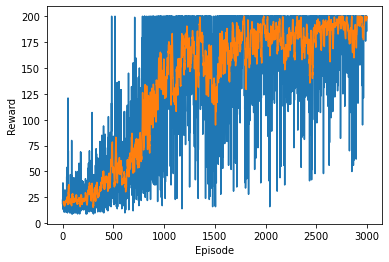

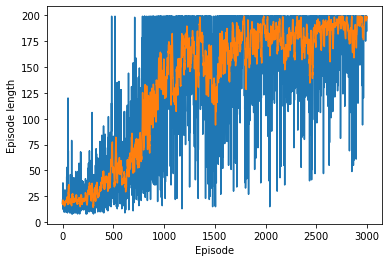

In [8]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.show()

PPO :  
https://medium.com/intro-to-artificial-intelligence/proximal-policy-optimization-ppo-a-policy-based-reinforcement-learning-algorithm-3cf126a7562d
https://towardsdatascience.com/understanding-and-implementing-proximal-policy-optimization-schulman-et-al-2017-9523078521ce  

Continuous action space :  
https://medium.com/@asteinbach/rl-introduction-simple-actor-critic-for-continuous-actions-4e22afb7121